1. **Load the data**: The first step for model building is of course to load the dataset 
 
2. **Preprocessing**: Depending on the dataset, the steps of preprocessing will be defined. This will include creating timestamps, converting the dtype of date/time column, making the series univariate, etc.
3. **Make series stationary**: In order to satisfy the assumption, it is necessary to make the series stationary. This would include checking the stationarity of the series and performing required transformations
4. **Determine d value**: For making the series stationary, the number of times the difference operation was performed will be taken as the d value
5. **Create ACF and PACF plots**: This is the most important step in ARIMA implementation. ACF PACF plots are used to determine the input parameters for our ARIMA model
6. **Determine the p and q values**: Read the values of p and q from the plots in the previous step
7. **Fit ARIMA model**: Using the processed data and parameter values we calculated from the previous steps, fit the ARIMA model
8. **Predict values on validation set**: Predict the future values
9. **Calculate RMSE**: To check the performance of the model, check the RMSE value using the predictions and actual values on the validation set

In [1]:
from pathlib import Path

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [5]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
directory = r'D:\DataSource\timeseries'
file_name = 'stock_prices_sample.csv'
dir_path = Path(directory)
file_path  = dir_path.joinpath(file_name)

In [7]:
stock_df = pd.read_csv(file_path,index_col=['DATE'], parse_dates=['DATE'])

In [8]:
#stock_df['DATE'] = pd.to_datetime(stock_df['DATE'],)

In [9]:
#stock_df.set_index(stock_df['DATE'],inplace=True)

In [10]:
stock_df.head()

,TICKER,FIGI,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
DATE,,,,,,,,,,,,,,,,,
2013-01-04,GEF,BBG000BLFQH8,EOD,daily,46.31,47.6198,46.23,47.37,248000.0,38.517220,39.606614,38.450681,39.398849,248000.0,NaN,0.0,1.0
2013-01-03,GEF,BBG000BLFQH8,EOD,daily,46.43,46.5200,46.14,46.48,131300.0,38.617027,38.691882,38.375826,38.658613,131300.0,NaN,0.0,1.0
2013-01-02,GEF,BBG000BLFQH8,EOD,daily,45.38,46.5400,45.16,46.41,184900.0,37.743715,38.708516,37.560735,38.600392,184900.0,NaN,0.0,1.0
2018-06-05,GF,BBG000C3C6S2,Intraday,daily,18.86,18.9100,18.87,18.87,10000.0,18.860000,18.910000,18.870000,18.870000,10000.0,NaN,0.0,1.0
2018-06-04,GF,BBG000C3C6S2,EOD,daily,18.86,18.8900,18.79,18.81,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,NaN,0.0,1.0


In [11]:
stock_df = stock_df[stock_df['TYPE']=='EOD']
stock_df = stock_df[stock_df['TICKER'] != 'GEF']


In [12]:
stock_df.shape

(995, 17)

In [13]:
drop_cols = ['SPLIT_RATIO', 'EX_DIVIDEND', 'ADJ_FACTOR', 'ADJ_VOLUME', 'ADJ_CLOSE', 'ADJ_LOW', 'ADJ_HIGH', 'ADJ_OPEN', 'VOLUME', 'FREQUENCY', 'TYPE', 'FIGI']
stock_df.drop(drop_cols, axis=1, inplace=True)

In [14]:
stock_df.head()

,TICKER,OPEN,HIGH,LOW,CLOSE
DATE,,,,,
2018-06-04,GF,18.86,18.890,18.7900,18.8100
2018-06-01,GF,18.58,18.760,18.5800,18.7400
2018-05-31,GF,18.52,18.520,18.3012,18.4900
2018-05-30,GF,18.47,18.678,18.4700,18.6500
2018-05-29,GF,18.51,18.510,18.1500,18.2562


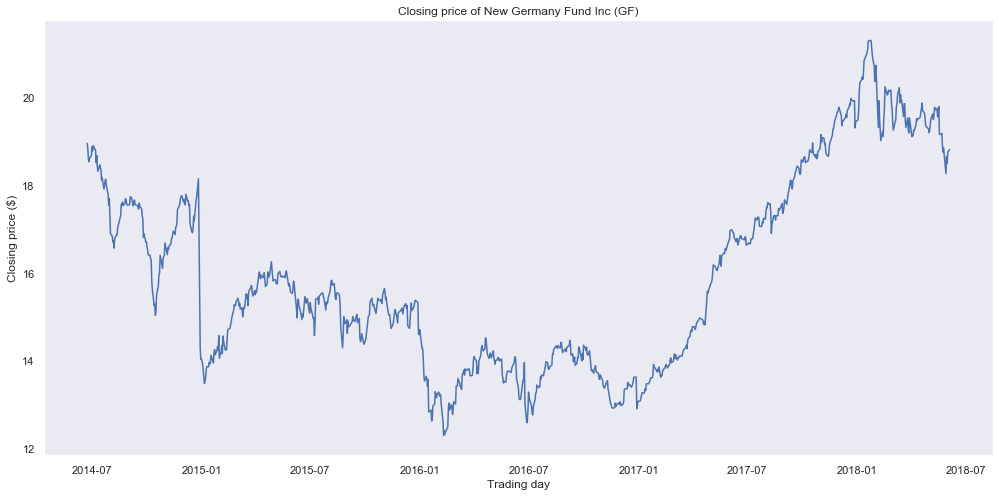

In [15]:
plt.figure(figsize=(17, 8))
plt.plot(stock_df['CLOSE'])
plt.title('Closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

#### ADF (Augmented Dickey Fuller) Test
The Dickey Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test are:

**Null Hypothesis**: The series has a unit root (value of a =1)

**Alternate Hypothesis**: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary (we will understand more about difference stationary in the next section).

In [16]:
#define function for ADF test 
from statsmodels.tsa.stattools import adfuller 

def adf_test(timeseries): #Perform Dickey-Fuller test:     
    print('Results of Dickey-Fuller Test:')     
    dftest = adfuller(timeseries, autolag='AIC')     
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])     
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value     
        print (dfoutput) 
 


In [17]:
adf_test(stock_df['CLOSE'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.471663
p-value                          0.547480
#Lags Used                       0.000000
Number of Observations Used    994.000000
Critical Value (1%)             -3.436946
dtype: float64
Test Statistic                  -1.471663
p-value                          0.547480
#Lags Used                       0.000000
Number of Observations Used    994.000000
Critical Value (1%)             -3.436946
Critical Value (5%)             -2.864452
dtype: float64
Test Statistic                  -1.471663
p-value                          0.547480
#Lags Used                       0.000000
Number of Observations Used    994.000000
Critical Value (1%)             -3.436946
Critical Value (5%)             -2.864452
Critical Value (10%)            -2.568321
dtype: float64


**Test for stationarity**: If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).

In our above example, the test statistic > critical value, which implies that the series is not stationary.

#### KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test

KPSS is another test for checking the stationarity of a time series (slightly less popular than the Dickey Fuller test). The null and alternative hypothesis for the KPSS test are opposite that of the ADF test, which often creates confusion.

The authors of the KPSS test have defined the null hypothesis as the process is trend stationary, to an alternate hypothesis of a unit root series. We will understand the trend stationarity in detail in the next section. For now, let’s focus on the implementation and see the results of the KPSS test.

**Null Hypothesis**: The process is trend stationary.

**Alternate Hypothesis**: The series has a unit root (series is not stationary).

In [18]:
from statsmodels.tsa.stattools import kpss 
#define KPSS 
def kpss_test(timeseries):    
    print('Results of KPSS Test:')    
    kpsstest = kpss(timeseries, regression='c',nlags ='auto')    
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])    
    for key,value in kpsstest[3].items():    
        kpss_output['Critical Value (%s)'%key] = value 
        print (kpss_output)

In [19]:
kpss_test(stock_df['CLOSE'])

Results of KPSS Test:
Test Statistic           1.618443
p-value                  0.010000
Lags Used               19.000000
Critical Value (10%)     0.347000
dtype: float64
Test Statistic           1.618443
p-value                  0.010000
Lags Used               19.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
dtype: float64
Test Statistic            1.618443
p-value                   0.010000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
dtype: float64
Test Statistic            1.618443
p-value                   0.010000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


**Test for stationarity**: If the test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary). If the test statistic is less than the critical value, if fail to reject the null hypothesis (series is stationary).

#### Types of Stationarity
Let us understand the different types of stationarities and how to interpret the results of the above tests.

**Strict Stationary**: A strict stationary series satisfies the mathematical definition of a stationary process. For a strict stationary series, the mean, variance and covariance are not the function of time. The aim is to convert a non-stationary series into a strict stationary series for making predictions.

**Trend Stationary**: A series that has no unit root but exhibits a trend is referred to as a trend stationary series. Once the trend is removed, the resulting series will be strict stationary. The KPSS test classifies a series as stationary on the absence of unit root. This means that the series can be strict stationary or trend stationary.
**Difference Stationary**: A time series that can be made strict stationary by differencing falls under difference stationary. ADF test is also known as a difference stationarity test.

It’s always better to apply both the tests, so that we are sure that the series is truly stationary. Let us look at the possible outcomes of applying these stationary tests.

> **Case 1**: Both tests conclude that the series is not stationary -> series is not stationary

> **Case 2**: Both tests conclude that the series is stationary -> series is stationary

> **Case 3**: KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary

> **Case 4**: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

#### 4. Making a Time Series Stationary
Now that we are familiar with the concept of stationarity and its different types, we can finally move on to actually making our series stationary. Always keep in mind that in order to use time series forecasting models, it is necessary to convert any non-stationary series to a stationary series first.

In [20]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

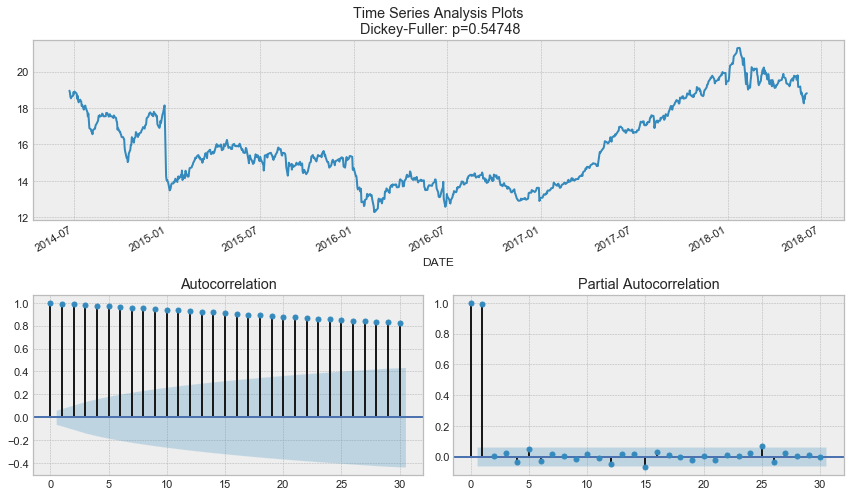

In [21]:
tsplot(stock_df['CLOSE'], lags=30)

In [22]:
data_diff = stock_df['CLOSE'] - stock_df['CLOSE'].shift(1)


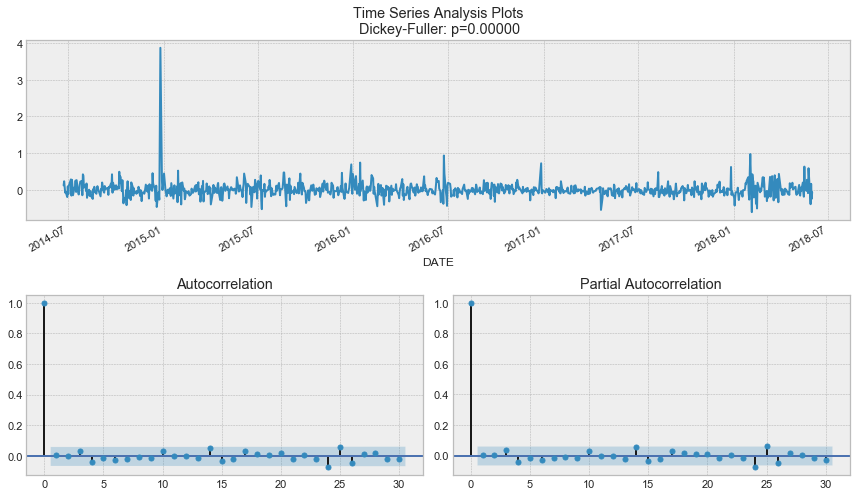

In [23]:
tsplot(data_diff[1:], lags=30)

#### ARIMA-family Crash-Course
A few words about the model. Letter by letter we’ll build the full name — SARIMA(p,d,q)(P,D,Q,s), Seasonal Autoregression Moving Average model:

>**AR(p)** — autoregression model, i.e., regression of the time series onto itself. Basic assumption — current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as p. To determine the initial p you need to have a look at PACF plot — find the biggest significant lag, after which most other lags are becoming not significant.

>**MA(q)** — moving average model. Without going into detail it models the error of the time series, again the assumption is — current error depends on the previous with some lag, which is referred to as q. Initial value can be found on ACF plot with the same logic.

Let’s have a small break and combine the first 4 letters:

####  AR(p) + MA(q) = ARMA(p,q)

What we have here is the Autoregressive–moving-average model! If the series is stationary, it can be approximated with those 4 letters. Shall we continue?

>**I(d)**— order of integration. It is simply the number of nonseasonal differences needed for making the series stationary. In our case it’s just 1, because we used first differences.

Adding this letter to four previous gives us ARIMA model which knows how to handle non-stationary data with the help of nonseasonal differences. Awesome, last letter left!

>**S(s)** — this letter is responsible for seasonality and equals the season period length of the series

After attaching the last letter we find out that instead of one additional parameter we get three in a row — (P,D,Q)

>**P** — order of autoregression for seasonal component of the model, again can be derived from PACF, but this time you need to look at the number of significant lags, which are the multiples of the season period length, for example, if the period equals 24 and looking at PACF we see 24-th and 48-th lags are significant, that means initial P should be 2.

>**Q** — same logic, but for the moving average model of the seasonal component, use ACF plot

>**D** — order of seasonal integration. Can be equal to 1 or 0, depending on whether seasonal differences were applied or not

#### SARIMA

In [24]:
#Set initial values and some bounds
ps = range(0, 4)
d = 1
qs = range(0, 4)
Ps = range(0, 4)
D = 1
Qs = range(0, 4)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(stock_df['CLOSE'], order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(stock_df['CLOSE'], order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())


                                         SARIMAX Results                                         
Dep. Variable:                                     CLOSE   No. Observations:                  995
Model:             SARIMAX(0, 1, 0)x(3, 1, [1, 2, 3], 5)   Log Likelihood                 148.873
Date:                                   Sat, 06 Jun 2020   AIC                           -283.746
Time:                                           22:46:28   BIC                           -249.470
Sample:                                                0   HQIC                          -270.712
                                                   - 995                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L5       -0.5645      0.140     -4.032      0.000   

In [25]:
p, q, P, Q = result_table.parameters[0]

In [29]:
result_table.parameters[0]
# (0, 0, 3, 3)

(0, 0, 3, 3)

In [31]:
import numpy as np

In [32]:
def plot_SARIMA(series, model, n_steps):
    """
        Plot model vs predicted values
        
        series - dataset with time series
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    
    data = series.copy().rename(columns = {'CLOSE': 'actual'})
    data['arima_model'] = model.fittedvalues
    #Make a shift on s+d steps, because these values were unobserved by the model due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    #Forecast on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    #Calculate error
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(data, label='actual')
    plt.legend()
    plt.grid(True);
    
# plot_SARIMA(data, best_model, 5)
print(best_model.predict(start=stock_df['CLOSE'].shape[0], end=stock_df['CLOSE'].shape[0] + 5))
print(mean_absolute_percentage_error(stock_df['CLOSE'][s+d:], best_model.fittedvalues[s+d:]))


995     18.958977
996     18.967220
997     18.960918
998     18.923275
999     18.943573
1000    18.921136
dtype: float64
0.7853997495898077
